In [ ]:
# !pip install --upgrade gspread google-auth

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Lambda
from keras import backend as K
from keras.losses import MeanSquaredError
from sklearn.linear_model import LinearRegression
import torch


# Load Data

In [ ]:
import gspread
from google.colab import auth
from google.auth import default
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
url = 'https://docs.google.com/spreadsheets/d/1EdpPnSUV8p_rcWf_ws8OrdeJLAQUcVKaBrLzgn3VE6Y/edit#gid=1575159049'
sheet_id = url.split('/')[-2]  # Extracts the sheet ID from the URL
worksheet = gc.open_by_key(sheet_id).sheet1
rows = worksheet.get_all_values()

# Convert to a DataFrame
df = pd.DataFrame(rows[1:], columns=rows[0])
df.iloc[:, [3, 4, 5, 6]] = df.iloc[:, [3, 4, 5, 6]].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)


# Visualize Data

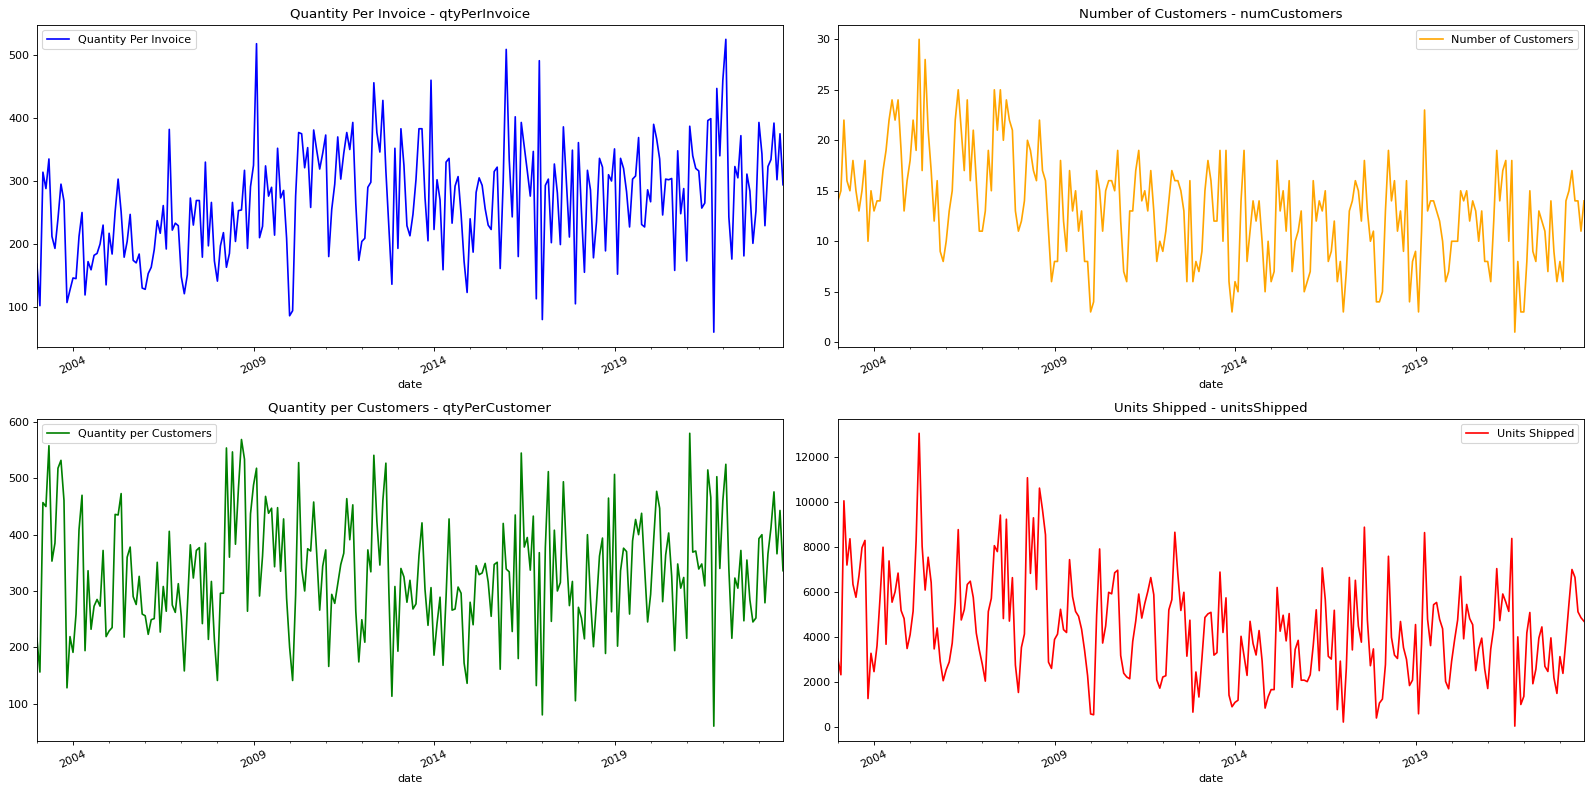

In [ ]:
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'], format='%Y%B')

titles = [
    "Quantity Per Invoice",
    "Number of Customers",
    "Quantity per Customers",
    "Units Shipped",
]

feature_keys = [
    "qtyPerInvoice",
    "numCustomers",
    "qtyPerCustomer",
    "unitsShipped"
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
]

date_time_key = "date"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(20, 10), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

# Data Pre-Processing

In [ ]:
# Convert quarter to categorical one-hot
one_hot = pd.get_dummies(df['quarter'])
df = df.join(one_hot)
df.head()

,year,quarter,month,qtyPerInvoice,numCustomers,qtyPerCustomer,unitsShipped,date,Q1,Q2,Q3,Q4
0,2003,Q1,January,168,14,216,3030,2003-01-01,1,0,0,0
1,2003,Q1,February,102,15,156,2339,2003-02-01,1,0,0,0
2,2003,Q1,March,314,22,457,10055,2003-03-01,1,0,0,0
3,2003,Q2,April,288,16,450,7205,2003-04-01,0,1,0,0
4,2003,Q2,May,335,15,558,8372,2003-05-01,0,1,0,0


In [ ]:
  # Convert month to sinusoidal
month_dict = {'January': 1,
              'February': 2,
              'March': 3,
              'April': 4,
              'May': 5,
              'June': 6,
              'July': 7,
              'August': 8,
              'September': 9,
              'October': 10,
              'November': 11,
              'December': 12}

df['month_idx'] = df['month'].map(month_dict)
df['month_sin'] = np.sin((df['month_idx'] - 1) * (2 * np.pi / 12))
df['month_cos'] = np.cos((df['month_idx'] - 1) * (2 * np.pi / 12))
df.head()

,year,quarter,month,qtyPerInvoice,numCustomers,qtyPerCustomer,unitsShipped,date,Q1,Q2,Q3,Q4,month_idx,month_sin,month_cos
0,2003,Q1,January,168,14,216,3030,2003-01-01,1,0,0,0,1,0.000000,1.000000e+00
1,2003,Q1,February,102,15,156,2339,2003-02-01,1,0,0,0,2,0.500000,8.660254e-01
2,2003,Q1,March,314,22,457,10055,2003-03-01,1,0,0,0,3,0.866025,5.000000e-01
3,2003,Q2,April,288,16,450,7205,2003-04-01,0,1,0,0,4,1.000000,6.123234e-17
4,2003,Q2,May,335,15,558,8372,2003-05-01,0,1,0,0,5,0.866025,-5.000000e-01


In [ ]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df[['qtyPerInvoice',
                                           'numCustomers',
                                           'qtyPerCustomer',
                                           'unitsShipped',
                                           'month_sin',
                                           'month_cos']]) # [249, 6]

quarter_onehots = df[['Q1', 'Q2', 'Q3', 'Q4']].to_numpy() # [249, 4]
features = np.hstack([scaled_features, quarter_onehots]) # [249, 10]
print(features.shape)
# features[0]

(249, 10)


In [ ]:
# Scale the target
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(df[['unitsShipped']])[:, 0]
print(scaled_target.shape)
# scaled_target

(249,)


In [ ]:
X = features[:-1, :]
y = scaled_target[1:]

total_size = X.shape[0]
val_size = 12
test_size = 6
num_ignore = 17

train_steps = total_size - num_ignore - val_size - test_size
print(f'Training set runs up to {train_steps} steps')

X_train = X[:train_steps] #249 - 12 = 237
y_train = y[:train_steps]

X_val = X[train_steps:train_steps + val_size]
y_val = y[train_steps:train_steps + val_size]

X_te = X[train_steps + val_size:train_steps + val_size + test_size]
y_te = y[train_steps + val_size:train_steps + val_size + test_size]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_te.shape, y_te.shape)

Training set runs up to 213 steps
(213, 10) (213,)
(12, 10) (12,)
(6, 10) (6,)


In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
X_te = torch.tensor(X_te, dtype=torch.float)

y_train = torch.tensor(y_train, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float)
y_te = torch.tensor(y_te, dtype=torch.float)

# PyTorch Model Construction

In [ ]:
import torch
# The goal of LSTM to 'improve' h_t, using various gates, such that h_t can be linearly transformed to equal y_t
class LSTMPredictor(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers=1, lstm_dropout=0., linear_dropout=0.):
        super().__init__()
        #input_dim: The number of features in the input data. It specifies the size of the input at each time step of the sequence, x_t
        #hidden_dim: The number of features in the hidden state of the LSTM. It determines the size of the output from the LSTM layer for each time step, h_t
        #num_layers: the number of layers in a stacked/heirarchical LSTM
        #lstm_dropout: prob of dropping out h_t in a stacked LSTM.
        #dropout appears to be used only in stacked LSTM's.
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=lstm_dropout)
        #linear layer: initialize the parameters A and b used to predict y_t
        #input: h_t; output: y_t
        self.linear = torch.nn.Linear(hidden_dim, 1)
        # linear_dropout is an arguement and tells us probability of dropping out h_t before the linear layer.
        self.drop = torch.nn.Dropout(p=linear_dropout)
        #initial hiden/cell state. We feed it a tensor of zeros. But as we train these parameters will be updated.
        self.h_0 = torch.nn.Parameter(torch.zeros(num_layers, hidden_dim))
        self.c_0 = torch.nn.Parameter(torch.zeros(num_layers, hidden_dim))
        self.start_hid = (self.h_0, self.c_0)

    def __call__(self, input_seq, start_hid=None):
        if start_hid is None:
            start_hid = self.start_hid
        #input_seq: tensor of shape [num time steps x features]
        #hid_seq: tensor of h_t vectors, will have shape [236, 64], hid_seq[10] is the value of h_t at timestep 10. it will have shape [64,]
        #last_hid: tuple of tensors, (h_236, c_236), with shapes [1, 64]
        hid_seq, last_hid = self.lstm(input_seq, start_hid)
        # For each timestep, self.linear computes y_t = h_t A^T + b (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
        # We are computing y_t simultaneously for each time step
        # Indexing with [:, 0] gets rid of the dimension equal to 1. Before indexing, has shape [236, 1] and after it has shape [236,].
        output = self.linear(self.drop(hid_seq))[:,0] # prediction for all time steps, vector of length equal to number of time steps
        return output, last_hid

class ShortcutLSTMPredictor(LSTMPredictor):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear = torch.nn.Linear(kwargs['input_dim'] + kwargs['hidden_dim'], 1)

    def __call__(self, input_seq, start_hid=None):
        if start_hid is None:
            start_hid = self.start_hid
        hid_seq, last_hid = self.lstm(input_seq, start_hid)
        output = self.linear(torch.hstack([input_seq, hid_seq]))[:,0]
        return output, last_hid

model = LSTMPredictor(input_dim=X_train.shape[1], hidden_dim=64, num_layers=2)

out, last_hid = model.__call__(torch.tensor(X_train, dtype=torch.float)) # equivalent to model(torch.tensor(X_train, dtype=torch.float))
print(out.shape)
print(last_hid[0].shape)
print(last_hid[1].shape)

with torch.no_grad():
    v_out, _ = model(torch.tensor(X_val, dtype=torch.float), last_hid)

print(v_out.shape)

<ipython-input-13-e3a96ff801b1>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, last_hid = model.__call__(torch.tensor(X_train, dtype=torch.float)) # equivalent to model(torch.tensor(X_train, dtype=torch.float))


torch.Size([213])
torch.Size([2, 64])
torch.Size([2, 64])
torch.Size([12])


<ipython-input-13-e3a96ff801b1>:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_out, _ = model(torch.tensor(X_val, dtype=torch.float), last_hid)


In [ ]:
model = LSTMPredictor(input_dim=X_train.shape[1], hidden_dim=64, num_layers=1)

num_steps = 2000
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
log_every = 40
log = {'step': [], 'loss': [], 'val_loss': []}
total_loss = 0.
total_val_loss = 0.
best_val_loss = float('inf')

#TRAINING
for step in range(1, num_steps + 1):
    # Perform gradient descent step
    preds, last_hid = model(X_train)
    #y_train and preds: vectors of length 236
    loss = torch.mean((y_train - preds)**2)
    #back propogation
    #torch knows what the parameters are in the model, using LSTM, Linear class from torch.nn.Module
    #LSTM parameters: input, forget, output, and cell state update
    #Linear parameters: A matrix, b vector in the linear transformation from h_t to y_t
    loss.backward()
    #loss.item: when you call .item() it retreives numbers from a tensor, this is a pytorch function
    #loss only has 1 number
    total_loss += loss.item()
    #when we run an interation of our model, torch.nn.Module stores all parameter values
    #when we run loss.backward() the gradients are computed
    #when we run optimizer.step() the parameters are updated
    optimizer.step()
    #need to zero out the gradients for the next iteration, otherwise torch will add the old gradients
    #with the new gradients, which doesn't make sense.
    optimizer.zero_grad()

    # Compute the validation loss
    #no_grad():
    with torch.no_grad():
      #last_hid: think of this as h_0 in our new set of data, the validation set
      #X_val is the input data
        val_preds, _ = model(X_val, last_hid)
        val_loss = torch.mean((y_val - val_preds)**2)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            #state_dict(): torch saving the best model as a file, named 'rnn_state.pt'
            torch.save(model.state_dict(), 'rnn_state.pt')

    total_val_loss += val_loss.item()


    if step % log_every == 0:
        avg_loss = total_loss / log_every
        avg_val_loss = total_val_loss / log_every

        log['step'].append(step)
        log['loss'].append(avg_loss)
        log['val_loss'].append(avg_val_loss)

        print(f'Step {step} | Train Loss {avg_loss} | Validation Loss {avg_val_loss} ')

        total_val_loss = 0.
        total_loss = 0.

model.load_state_dict(torch.load('rnn_state.pt'))

Step 40 | Train Loss 0.13737950390204787 | Validation Loss 0.12462953785434365 
Step 80 | Train Loss 0.032288294099271295 | Validation Loss 0.027646410511806607 
Step 120 | Train Loss 0.024629862792789937 | Validation Loss 0.022050153510645033 
Step 160 | Train Loss 0.01983386417850852 | Validation Loss 0.019320585392415525 
Step 200 | Train Loss 0.016968801664188505 | Validation Loss 0.018775061471387744 
Step 240 | Train Loss 0.014974587969481945 | Validation Loss 0.01935979714617133 
Step 280 | Train Loss 0.014141325722448528 | Validation Loss 0.01964289848692715 
Step 320 | Train Loss 0.013642025110311807 | Validation Loss 0.01987604796886444 
Step 360 | Train Loss 0.013280203472822905 | Validation Loss 0.02021906478330493 
Step 400 | Train Loss 0.013035576185211539 | Validation Loss 0.020609316881746054 
Step 440 | Train Loss 0.012863028421998024 | Validation Loss 0.020843748888000845 
Step 480 | Train Loss 0.012695481115952135 | Validation Loss 0.021009748615324498 
Step 520 | Tr

<All keys matched successfully>

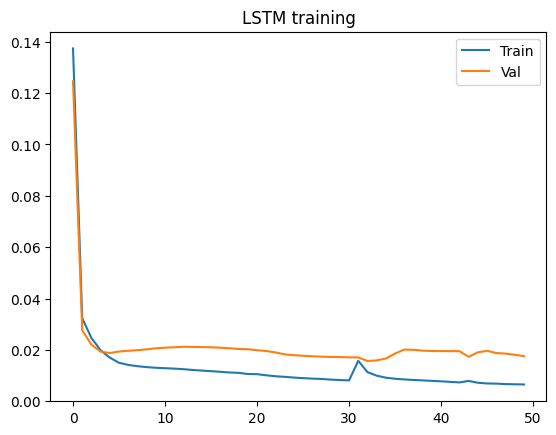

In [ ]:
fig, ax = plt.subplots()
ax.set_title("LSTM training")
ax.plot(log['loss'], label='Train')
ax.plot(log['val_loss'], label='Val')
ax.legend()

In [ ]:
with torch.no_grad():
    tr_preds, last_hid = model(X_train)
    val_preds, last_val_hid = model(X_val, last_hid)
    test_preds, last_test_hid = model(X_te, last_val_hid)
    last_pred, _ = model(torch.tensor(features[-1, :][None], dtype=torch.float), last_test_hid)

In [ ]:
y_train_ = scaler_target.inverse_transform(y_train[None])[0]
y_val_ = scaler_target.inverse_transform(y_val[None])[0]
y_test_ = scaler_target.inverse_transform(y_te[None])[0]
tr_preds_ = scaler_target.inverse_transform(tr_preds[None])[0]
val_preds_ = scaler_target.inverse_transform(val_preds[None])[0]
test_preds_ = scaler_target.inverse_transform(test_preds[None])[0]
last_pred_ = scaler_target.inverse_transform(last_pred[None])[0]

In [ ]:
def plot_preds(tr_preds_, val_preds_, test_preds_, title='Model Predictions'):
    fig, axes = plt.subplots(nrows=2, figsize=(20, 10))
    print(axes.shape)
    axes[0].set_title(title)
    axes[0].plot(np.concatenate([y_train_, y_val_, y_test_]), label='True',color='grey')
    axes[0].plot(np.concatenate([tr_preds_, val_preds_, test_preds_]), label='Predicted', color='blue')
    axes[0].axvline(train_steps, color='red')
    axes[0].axvline(train_steps + val_size, color='red')
    axes[0].legend(loc='best')

    axes[1].set_title('Residual')
    axes[1].set_ylim([-5000, 5000])
    axes[1].axhline(0, color='green')
    axes[1].plot(np.concatenate([tr_preds_ - y_train_, val_preds_ - y_val_, test_preds_ - y_test_]), label='Residual', color='orange')
    axes[1].axvline(train_steps, color='red')
    axes[1].axvline(train_steps + val_size, color='red')
    axes[1].legend(loc='best')
    return axes

(2,)


array([<Axes: title={'center': 'LSTM Predictions'}>,
       <Axes: title={'center': 'Residual'}>], dtype=object)

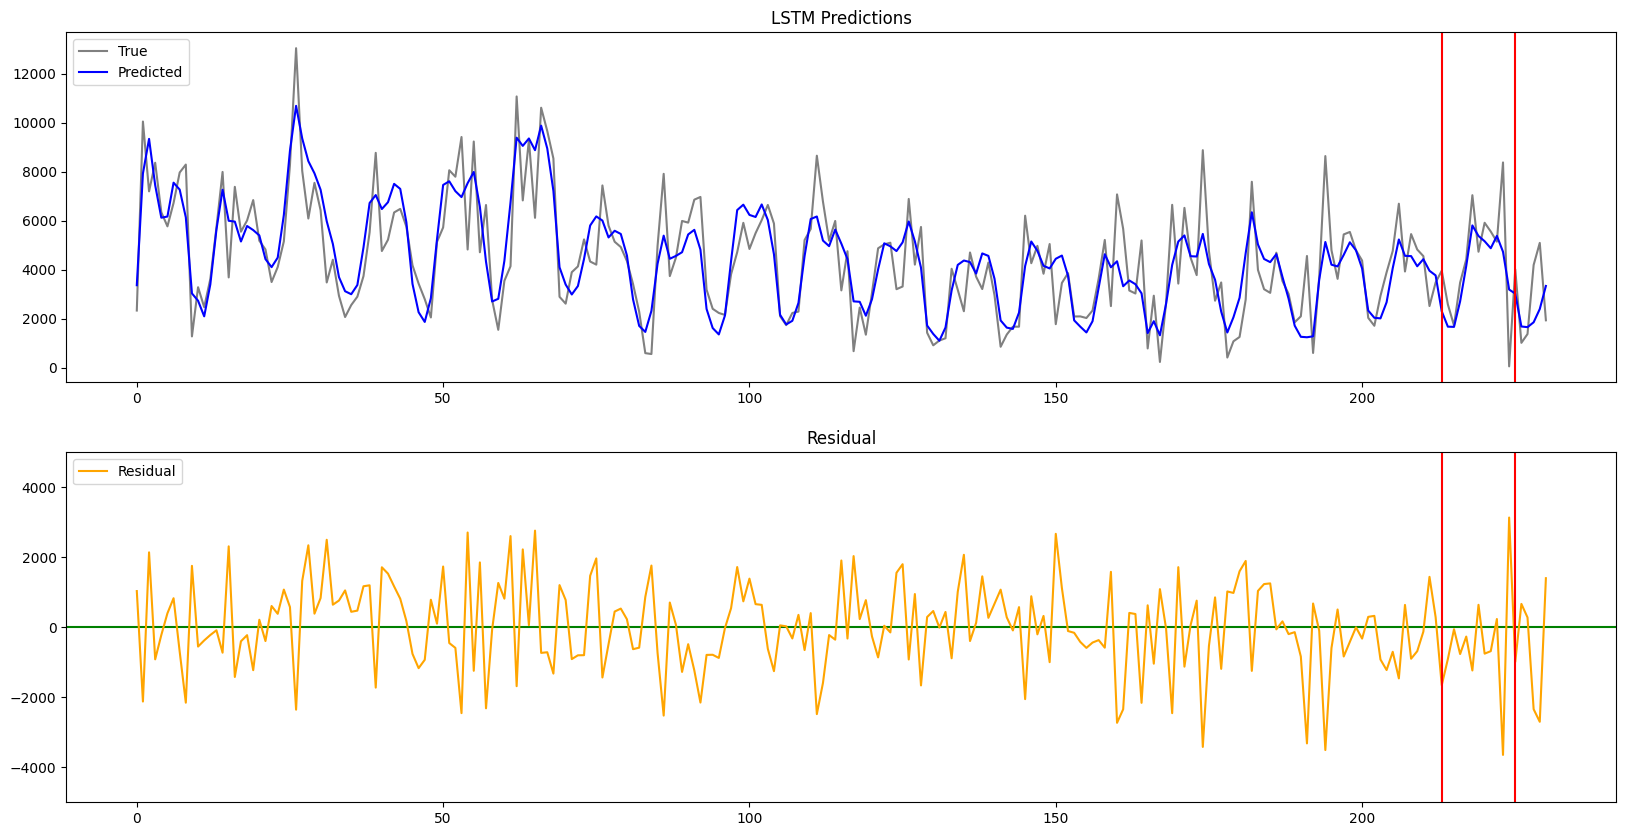

In [ ]:
plot_preds(tr_preds_, val_preds_, test_preds_, title='LSTM Predictions')

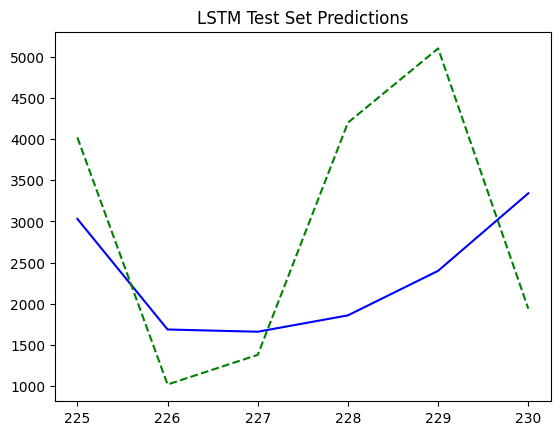

In [ ]:
fig, ax = plt.subplots()
ax.set_title('LSTM Test Set Predictions')
ax.plot(np.arange(train_steps + val_size, train_steps + val_size + test_size), test_preds_, label='Predicted', color='blue')
ax.plot(np.arange(train_steps + val_size, train_steps + val_size + test_size), y_test_, '--g', label='True')

In [ ]:
# Root mean squared error on validation set
lstm_val_rmse = np.sqrt(np.mean((y_val_ - val_preds_)**2)) # root mean squared error

# Root mean squared error on test set
lstm_test_rmse = np.sqrt(np.mean((y_test_ - test_preds_)**2))

print(f'Validation RMSE: {lstm_val_rmse}')
print(f'Test RMSE: {lstm_test_rmse}')

Validation RMSE: 1591.0596734422495
Test RMSE: 1645.2147849082924


In [ ]:
lstm_med_val_resid = np.median(np.abs(y_val_ - val_preds_))
lstm_med_test_resid = np.median(np.abs(y_test_ - test_preds_))

print(f'Median residual on validation {lstm_med_val_resid}')
print(f'Median residual on test {lstm_med_test_resid}')

Median residual on validation 759.1418037414551
Median residual on test 1195.7370453998446


# Stacked LSTM

In [ ]:
st_model = LSTMPredictor(input_dim=X_train.shape[1], hidden_dim=64, num_layers=2)

num_steps = 2000
optimizer = torch.optim.Adam(st_model.parameters(), lr=3e-4)
log_every = 40
log = {'step': [], 'loss': [], 'val_loss': []}
total_loss = 0.
total_val_loss = 0.
best_val_loss = float('inf')

for step in range(1, num_steps + 1):
    # Perform gradient descent step
    preds, last_hid = st_model(X_train)
    loss = torch.mean((y_train - preds)**2)
    loss.backward()
    total_loss += loss.item()

    optimizer.step()
    optimizer.zero_grad()

    # Compute the validation loss
    with torch.no_grad():
        val_preds, _ = st_model(X_val, last_hid)
        val_loss = torch.mean((y_val - val_preds)**2)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(st_model.state_dict(), 'st_rnn_state.pt')

    total_val_loss += val_loss.item()


    if step % log_every == 0:
        avg_loss = total_loss / log_every
        avg_val_loss = total_val_loss / log_every

        log['step'].append(step)
        log['loss'].append(avg_loss)
        log['val_loss'].append(avg_val_loss)

        print(f'Step {step} | Train Loss {avg_loss} | Validation Loss {avg_val_loss} ')

        total_val_loss = 0.
        total_loss = 0.

st_model.load_state_dict(torch.load('st_rnn_state.pt'))

Step 40 | Train Loss 0.0366745897103101 | Validation Loss 0.03153650825843215 
Step 80 | Train Loss 0.024719420447945596 | Validation Loss 0.021711118659004568 
Step 120 | Train Loss 0.01879252982325852 | Validation Loss 0.017703805258497594 
Step 160 | Train Loss 0.015161809977144003 | Validation Loss 0.01882581440731883 
Step 200 | Train Loss 0.013949186517857015 | Validation Loss 0.01901034787297249 
Step 240 | Train Loss 0.013135274522937834 | Validation Loss 0.019327262602746486 
Step 280 | Train Loss 0.012732239440083504 | Validation Loss 0.019638690538704394 
Step 320 | Train Loss 0.012370356963947416 | Validation Loss 0.019434574898332356 
Step 360 | Train Loss 0.011951807979494333 | Validation Loss 0.01915781362913549 
Step 400 | Train Loss 0.011478019459173084 | Validation Loss 0.019298061588779093 
Step 440 | Train Loss 0.010881551401689648 | Validation Loss 0.01957333106547594 
Step 480 | Train Loss 0.01023713075555861 | Validation Loss 0.01948604159988463 
Step 520 | Train

<All keys matched successfully>

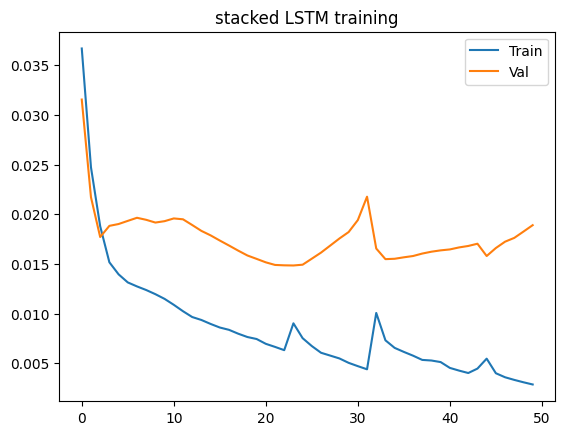

In [ ]:
fig, ax = plt.subplots()
ax.set_title("stacked LSTM training")
ax.plot(log['loss'], label='Train')
ax.plot(log['val_loss'], label='Val')
ax.legend()

In [ ]:
with torch.no_grad():
    st_tr_preds, last_hid = st_model(X_train)
    st_val_preds, last_val_hid = st_model(X_val, last_hid)
    st_test_preds, last_test_hid = st_model(X_te, last_val_hid)
    st_last_pred, _ = st_model(torch.tensor(features[-1, :][None], dtype=torch.float), last_test_hid)

In [ ]:
st_tr_preds_ = scaler_target.inverse_transform(st_tr_preds[None])[0]
st_val_preds_ = scaler_target.inverse_transform(st_val_preds[None])[0]
st_test_preds_ = scaler_target.inverse_transform(st_test_preds[None])[0]
st_last_pred_ = scaler_target.inverse_transform(st_last_pred[None])[0]

(2,)


array([<Axes: title={'center': 'Stacked LSTM Predictions'}>,
       <Axes: title={'center': 'Residual'}>], dtype=object)

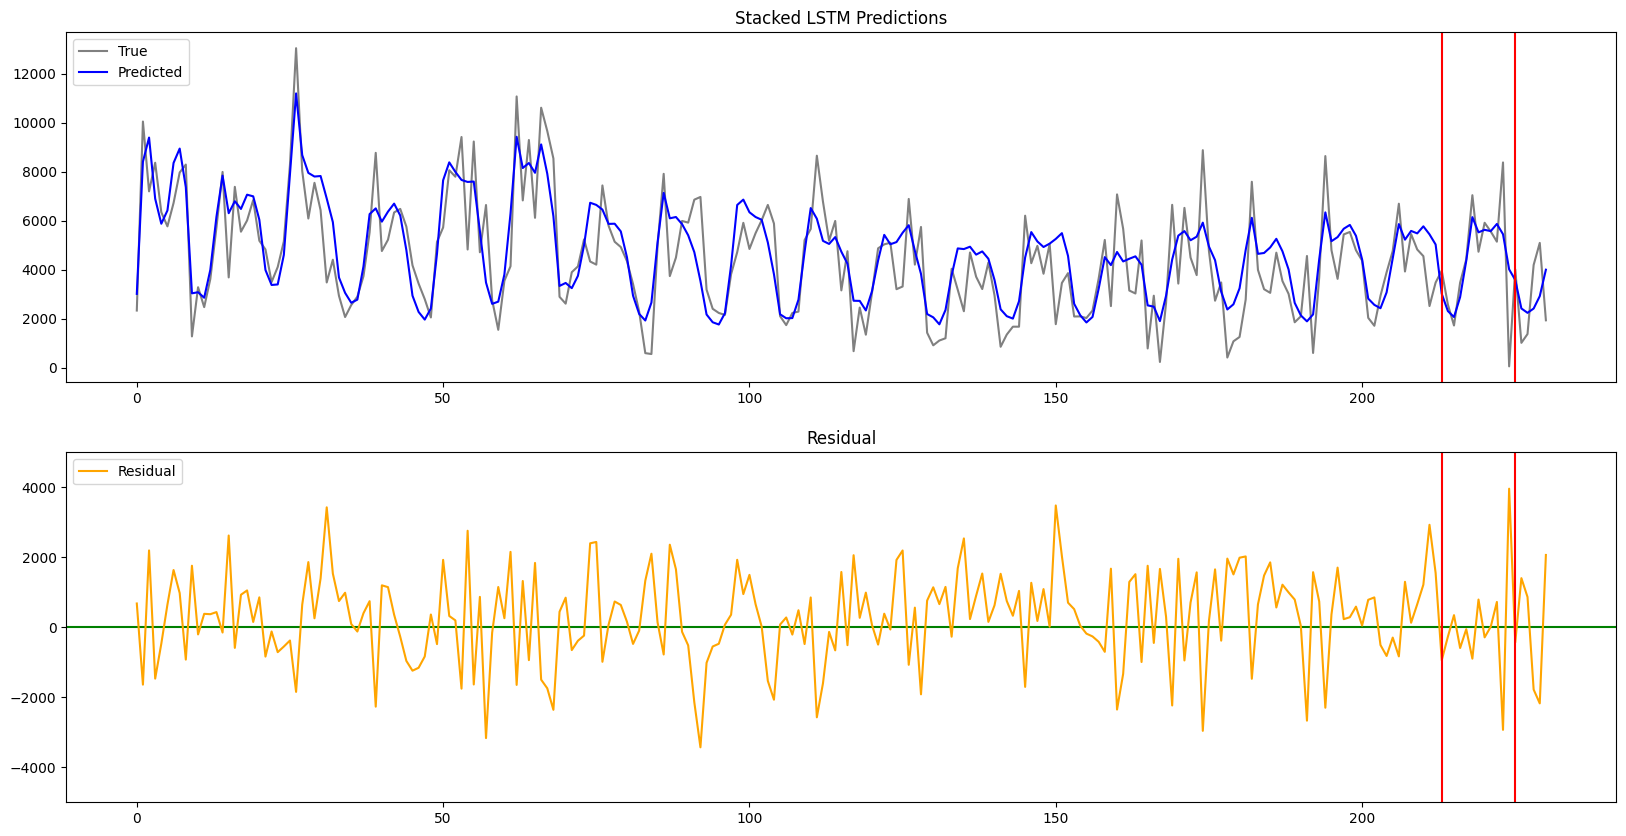

In [ ]:
plot_preds(st_tr_preds_, st_val_preds_, st_test_preds_, title='Stacked LSTM Predictions')

In [ ]:
# Root mean squared error on validation set
st_val_rmse = np.sqrt(np.mean((y_val_ - st_val_preds_)**2)) # root mean squared error

# Root mean squared error on test set
st_test_rmse = np.sqrt(np.mean((y_test_ - st_test_preds_)**2))

print(f'Stacked LSTM Validation RMSE: {st_val_rmse}')
print(f'Stacked LSTM Test RMSE: {st_test_rmse}')

Stacked LSTM Validation RMSE: 1520.488800462082
Stacked LSTM Test RMSE: 1584.9874302962874


In [ ]:
st_test_med_resid = np.median(np.abs(y_test_ - st_test_preds_))
print(f'Stacked LSTM Median Test Residual: {st_test_med_resid}')

Stacked LSTM Median Test Residual: 1591.5986180566251


# Linear Regression Baseline

In [ ]:
linear_model = LinearRegression().fit(X_train, y_train)

In [ ]:
linear_preds = linear_model.predict(X_train)
linear_preds_ = scaler_target.inverse_transform(linear_preds[None])[0]

In [ ]:
linear_val_preds = linear_model.predict(X_val)

In [ ]:
linear_test_preds = linear_model.predict(X_te)
linear_test_preds_ = scaler_target.inverse_transform(linear_test_preds[None])[0]

In [ ]:
linear_val_preds_ = scaler_target.inverse_transform(linear_val_preds[None])[0]

In [ ]:
linear_val_rmse = np.sqrt(np.mean((y_val_ - linear_val_preds_)**2))
print(f'OLS Val RMSE: {linear_val_rmse}')

OLS Val RMSE: 1953.8120212029446


In [ ]:
linear_test_rmse = np.sqrt(np.mean((y_test_ - linear_test_preds_)**2))
print(f'OLS Test RMSE: {linear_test_rmse}')

OLS Test RMSE: 2469.546716587834


(2,)


array([<Axes: title={'center': 'OLS Predictions'}>,
       <Axes: title={'center': 'Residual'}>], dtype=object)

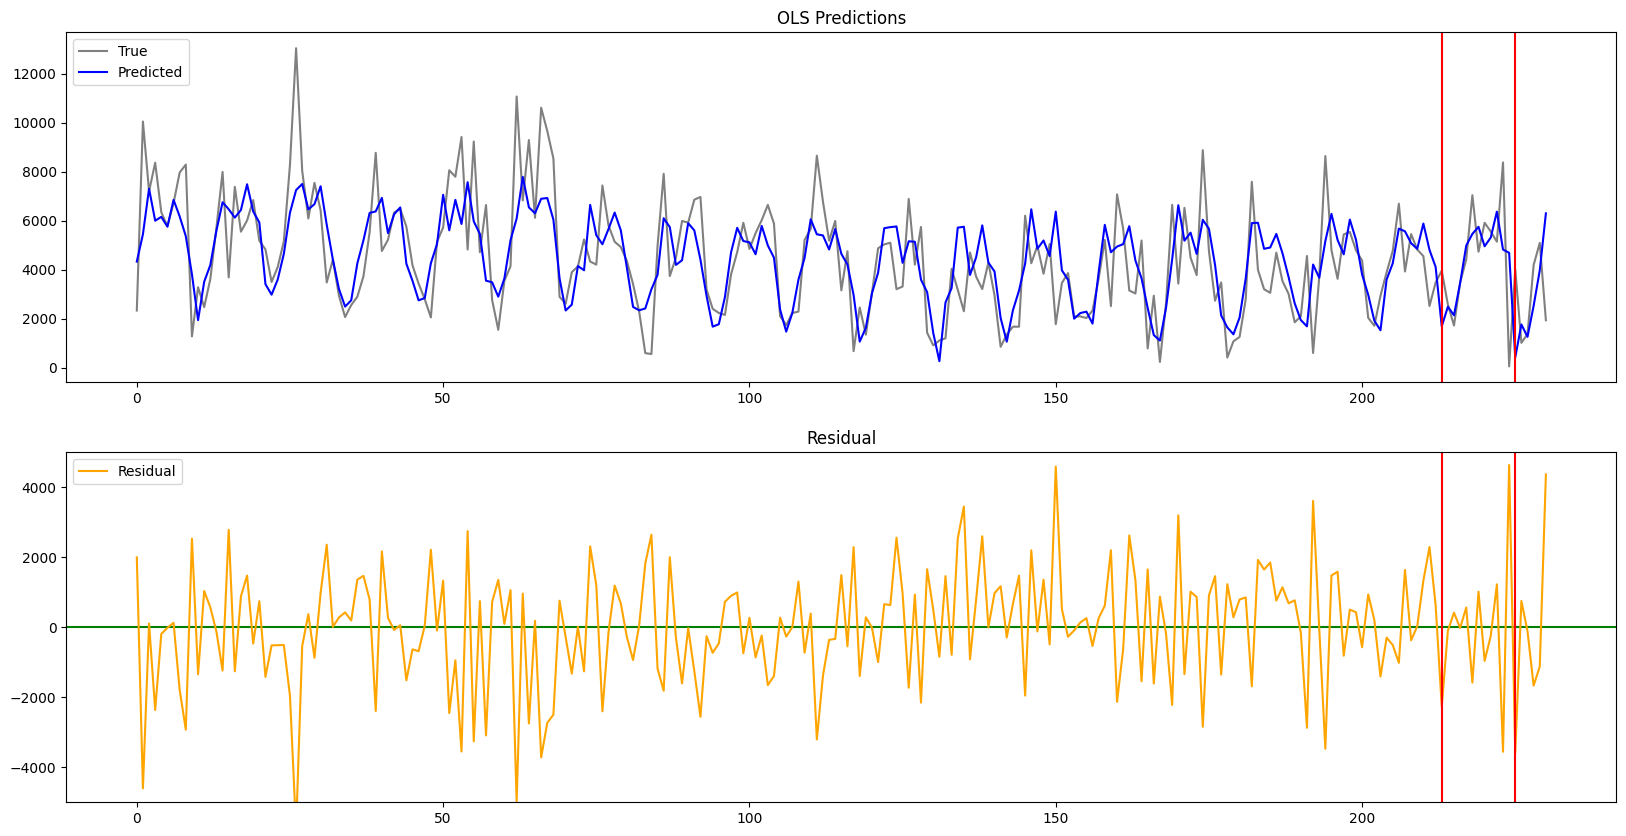

In [ ]:
plot_preds(linear_preds_, linear_val_preds_, linear_test_preds_, title='OLS Predictions')

# Feedforward Network Baseline

In [ ]:
from sklearn.neural_network import MLPRegressor
ffnn = MLPRegressor().fit(X_train, y_train)

In [ ]:
ffnn_pred = ffnn.predict(X_train)
ffnn_pred_= scaler_target.inverse_transform(ffnn_pred[None])[0]

In [ ]:
ffnn_val_preds = ffnn.predict(X_val)
ffnn_val_preds_ = scaler_target.inverse_transform(ffnn_val_preds[None])[0]
ffnn_val_rmse = np.sqrt(np.mean((y_val_ - ffnn_val_preds_)**2))
print(f'FFN Val RMSE: {ffnn_val_rmse}')

FFN Val RMSE: 2160.5881486335493


In [ ]:
ffnn_test_preds = ffnn.predict(X_te)
ffnn_test_preds_ = scaler_target.inverse_transform(ffnn_test_preds[None])[0]
ffnn_test_rmse = np.sqrt(np.mean((y_test_ - ffnn_test_preds_)**2))
print(f'FFN Test RMSE: {ffnn_test_rmse}')

FFN Test RMSE: 2056.94237641074


In [ ]:
ffnn_med_test_resid = np.median(np.abs(y_test_ - ffnn_test_preds_))
print(f'FFN Median Test Residual: {ffnn_med_test_resid}')

FFN Median Test Residual: 1178.5528180990507


(2,)


array([<Axes: title={'center': 'FFNN Predictions'}>,
       <Axes: title={'center': 'Residual'}>], dtype=object)

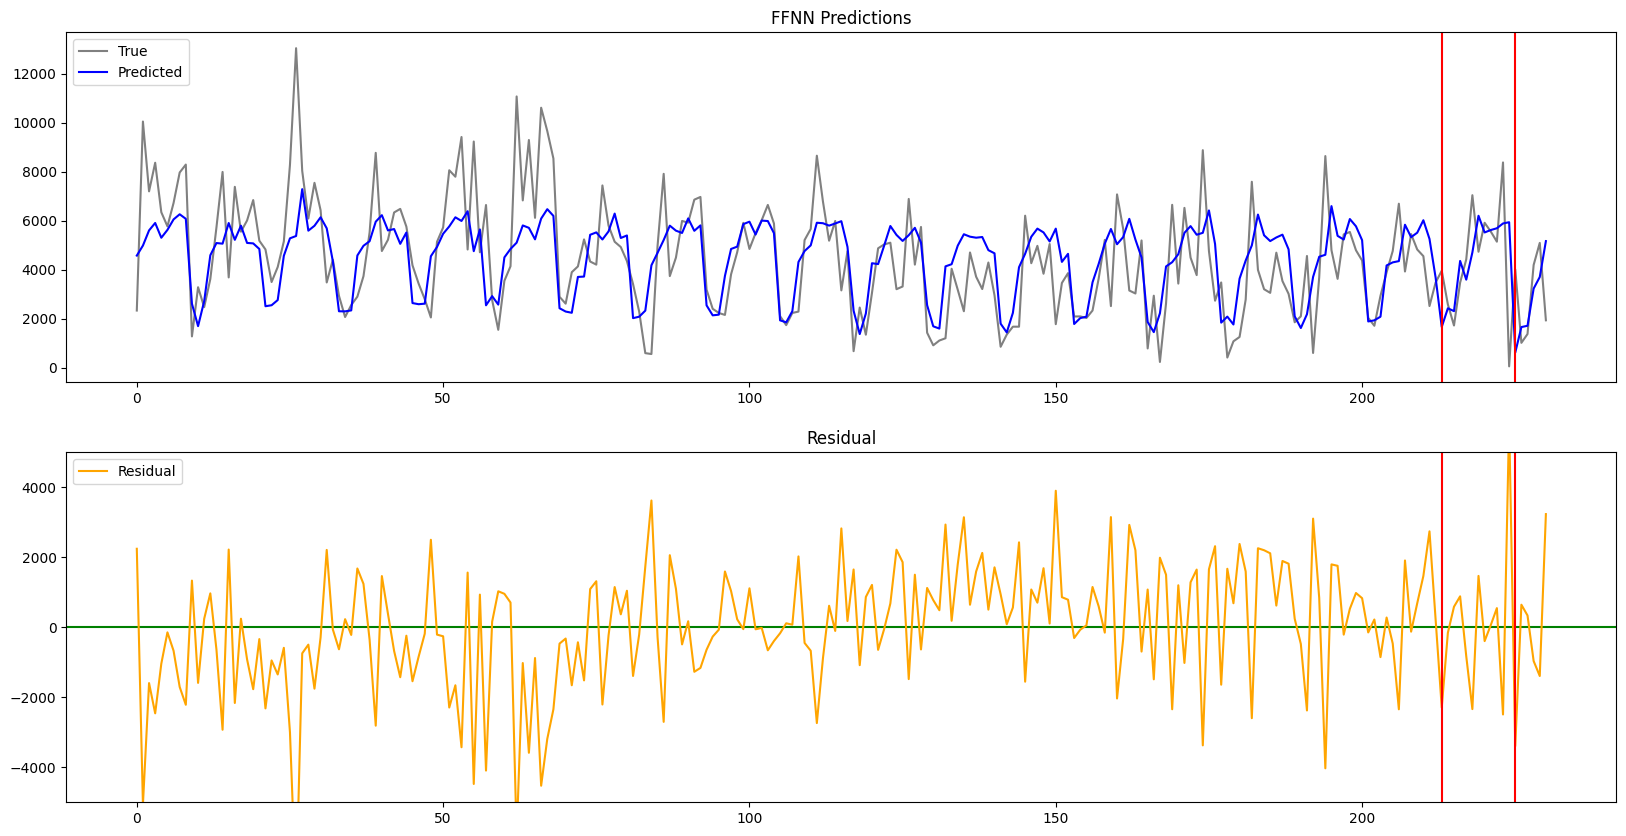

In [ ]:
plot_preds(ffnn_pred_, ffnn_val_preds_, ffnn_test_preds_, title='FFNN Predictions')

# Model Comparison

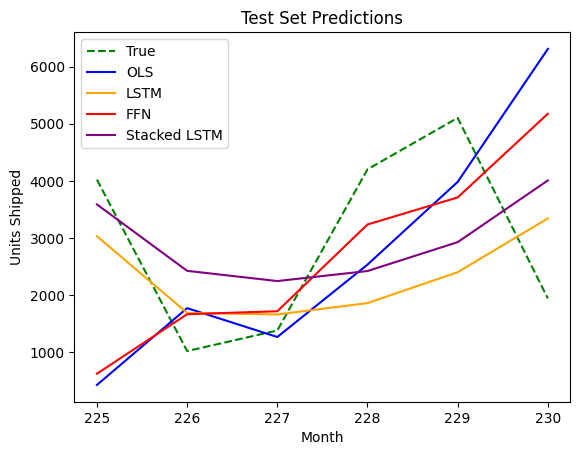

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Test Set Predictions')
ax.plot(np.arange(train_steps + val_size, train_steps + val_size + test_size), y_test_, '--g', label='True')
ax.plot(np.arange(train_steps + val_size, train_steps + val_size + test_size), linear_test_preds_, label='OLS', color='blue')
ax.plot(np.arange(train_steps + val_size, train_steps + val_size + test_size), test_preds_, label='LSTM', color='orange')
ax.plot(np.arange(train_steps + val_size, train_steps + val_size + test_size), ffnn_test_preds_, label='FFN', color='red')
ax.plot(np.arange(train_steps + val_size, train_steps + val_size + test_size), st_test_preds_, label='Stacked LSTM', color='purple')

ax.set_xlabel('Month')
ax.set_ylabel('Units Shipped')
ax.legend()

Text(0.5, 1.0, 'Test RMSE')

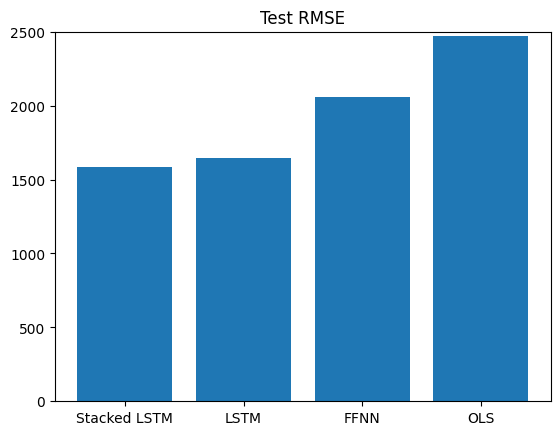

In [ ]:
fig, ax = plt.subplots()
ax.bar(['Stacked LSTM', 'LSTM', 'FFNN', 'OLS'], [st_test_rmse, lstm_test_rmse, ffnn_test_rmse, linear_test_rmse])
ax.set_ylim([0, 2500])
ax.set_title('Test RMSE')